In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image

parent_path = os.path.abspath('../src')
sys.path.append(parent_path)

from unet.rle import display_image_with_segmentation

In [2]:
TRAIN_FOLDER = '../data/train_v2/'
TRAIN_MASK = '../data/train_ship_segmentations_v2.csv'

In [3]:
img_sizes = []
img_to_drop = []
for file in tqdm(os.listdir(TRAIN_FOLDER)):
    try:
        img = plt.imread(os.path.join(TRAIN_FOLDER, file))
        shape = img.shape
        if shape not in img_sizes:
            img_sizes.append(img.shape)
    except Exception as e:
        print(f'Cannot read image: {file}')
        img_to_drop.append(file)
        continue

if len(img_sizes) == 1:
    IMAGE_SIZE = img_sizes[0]
    print(f'All images have the same size: {img_sizes[0]}')
else:
    print(f'Images have different sizes: {img_sizes}')

100%|██████████| 192555/192555 [17:11<00:00, 186.76it/s]

All images have the same size: (768, 768, 3)


### Luckily, we have all pictures with the same size. Let's try to provide the model with the same dimensionality of the images. Drop images that cannot be read.

In [4]:
for file in img_to_drop:
    os.remove(os.path.join(TRAIN_FOLDER, file))

### Read the segmentation data for next display

In [5]:
full_segmentation = pd.read_csv(TRAIN_MASK)
full_segmentation['EncodedPixels'] = full_segmentation['EncodedPixels'].fillna('')
full_segmentation = full_segmentation.groupby('ImageId')['EncodedPixels'].agg(' '.join).reset_index()
full_segmentation.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,0001b1832.jpg,
5,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
6,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...
7,0002d0f32.jpg,
8,000303d4d.jpg,
9,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...


### Read the input data for analysis

In [6]:
train_df = pd.read_csv(TRAIN_MASK)
train_df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


#### Display how many image with ships and how many image without ships

In [7]:
train_df['Ships'] = train_df['EncodedPixels'].map(lambda x: 1 if isinstance(x, str) else 0)
train_df

,ImageId,EncodedPixels,Ships
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


### For pictures find the actual number/fraction part of pixel of ships

In [8]:
def get_pixels(encoded_pixels: str) -> int:
    if not isinstance(encoded_pixels, str):
        return 0
    else:
        return np.array(encoded_pixels.split()[1::2], dtype=int).sum()

train_df['ShipsArea'] = train_df.apply(lambda x: get_pixels(x['EncodedPixels']), axis=1)
train_df.head(10)

,ImageId,EncodedPixels,Ships,ShipsArea
0,00003e153.jpg,NaN,0,0
1,0001124c7.jpg,NaN,0,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1,3388
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1,177
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1,148
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1,480
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,1,7
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...,1,648
8,0001b1832.jpg,NaN,0,0
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,1,400


In [9]:
ship_per_img = train_df.groupby('ImageId').agg({'Ships': 'sum', 'ShipsArea': 'sum'}).reset_index()
ship_per_img = ship_per_img.sort_values(by='Ships', ascending=False)
ship_per_img

,ImageId,Ships,ShipsArea
61000,5151bc5d2.jpg,15,988
65198,56d23b600.jpg,15,11033
69800,5ce0761c8.jpg,15,4239
95412,7ed6fd5e5.jpg,15,380
74031,626beb313.jpg,15,3198
...,...,...,...
72210,600680966.jpg,0,0
72211,6006df29c.jpg,0,0
72214,60079c8f7.jpg,0,0
72216,6008c43aa.jpg,0,0


In [10]:
ship_per_img['ShipPercentage'] = ship_per_img['ShipsArea'] / (IMAGE_SIZE[0] * IMAGE_SIZE[1]) * 100
ship_per_img

,ImageId,Ships,ShipsArea,ShipPercentage
61000,5151bc5d2.jpg,15,988,0.167508
65198,56d23b600.jpg,15,11033,1.870558
69800,5ce0761c8.jpg,15,4239,0.718689
95412,7ed6fd5e5.jpg,15,380,0.064426
74031,626beb313.jpg,15,3198,0.542196
...,...,...,...,...
72210,600680966.jpg,0,0,0.000000
72211,6006df29c.jpg,0,0,0.000000
72214,60079c8f7.jpg,0,0,0.000000
72216,6008c43aa.jpg,0,0,0.000000


In [11]:
avg_ship_per_all = ship_per_img["ShipPercentage"].mean()
print(f'Average ShipPercentage for ALL images: {round(avg_ship_per_all, 2)}%')

Average ShipPercentage for ALL images: 0.11%


In [12]:
ship_per_img_with_ships = ship_per_img[ship_per_img['ShipsArea'] != 0]

avg_ship_per_with_ships = ship_per_img_with_ships["ShipPercentage"].mean()
print(f'Average ShipPercentage for images WITH SHIPS: {round(avg_ship_per_with_ships, 2)}%')

Average ShipPercentage for images WITH SHIPS: 0.51%


### The fraction part of pixels in images with ships reaches `0.5%`, which is a relatively small number. But it is typical for segmentation tasks, where we have in many times more pixels that belong to the background class than to the foreground class.

### Display ship number distribution 

In [13]:
ships = ship_per_img['Ships'].value_counts()
ships

Ships
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64

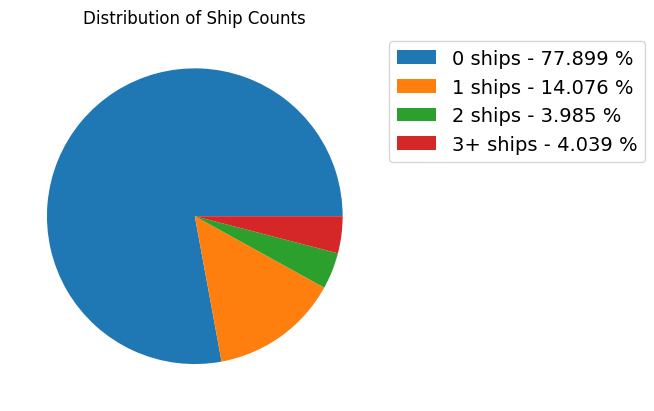

In [14]:
y = ships.values
full = y.sum()
percentage = 100

labels = []
for i in range(len(ships.index)):
    if i <= 2:
        percent = 100. * y[i] / y.sum()
        labels.append(f'{ships.index[i]} ships - {percent:.03f} %')
        full = full - y[i]
        percentage = percentage - percent

if percentage > 0:
    labels.append(f'3+ ships - {percentage:.03f} %')

ships = pd.concat([ships[:3], pd.Series(full, index=['3+ ships'])])

plt.pie(ships, labels=None)
plt.title('Distribution of Ship Counts')
plt.ylabel(None)

plt.legend(labels, bbox_to_anchor=(1., 1.), fontsize=14)

plt.show()

## This visualization and the previous thesis makes us understand that we are working with a distribution where images without ships are *`3 times`* larger than pictures with ships. We can conclude for the future about training the model on samples with ships and a small proportion of images without ships at all in order to find the best solution for the segmentation problem.

# Image displaying
#### Image without any ships

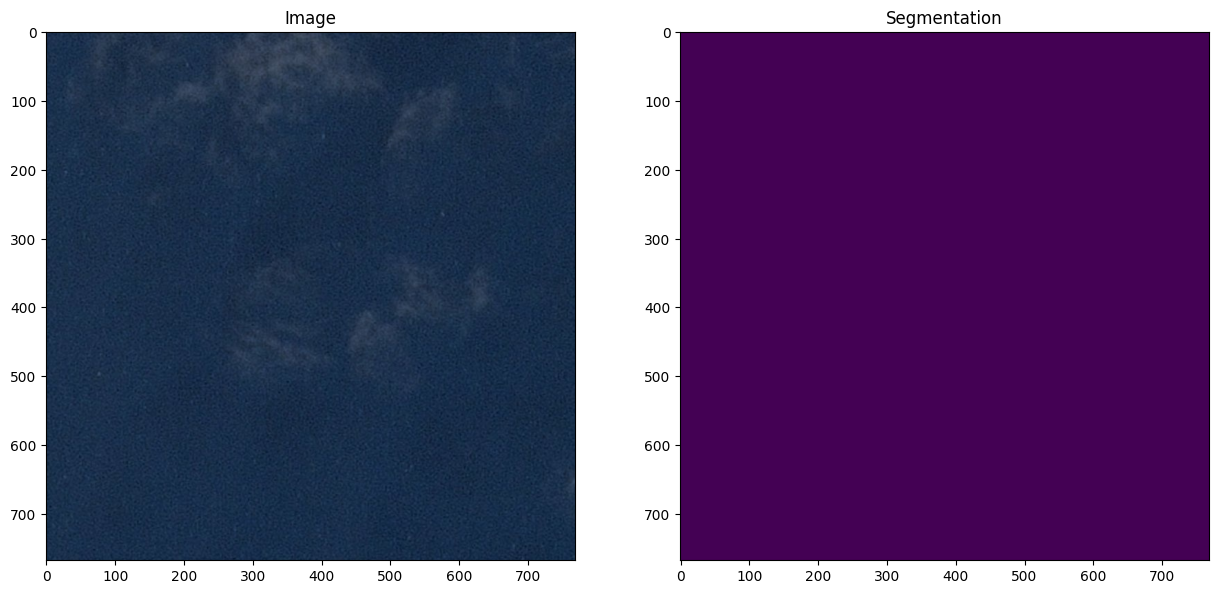

In [15]:
display_image_with_segmentation('00003e153.jpg', full_segmentation, TRAIN_FOLDER)

#### Image with 1 ship

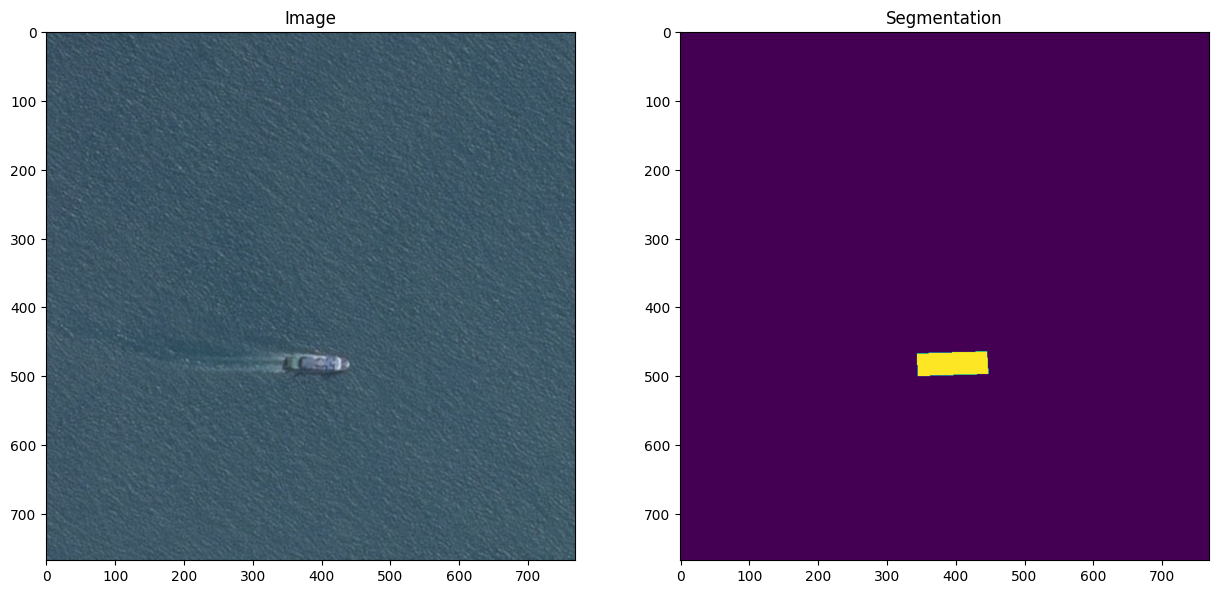

In [16]:
display_image_with_segmentation('000155de5.jpg', full_segmentation, TRAIN_FOLDER)

#### Image with 2+ ships

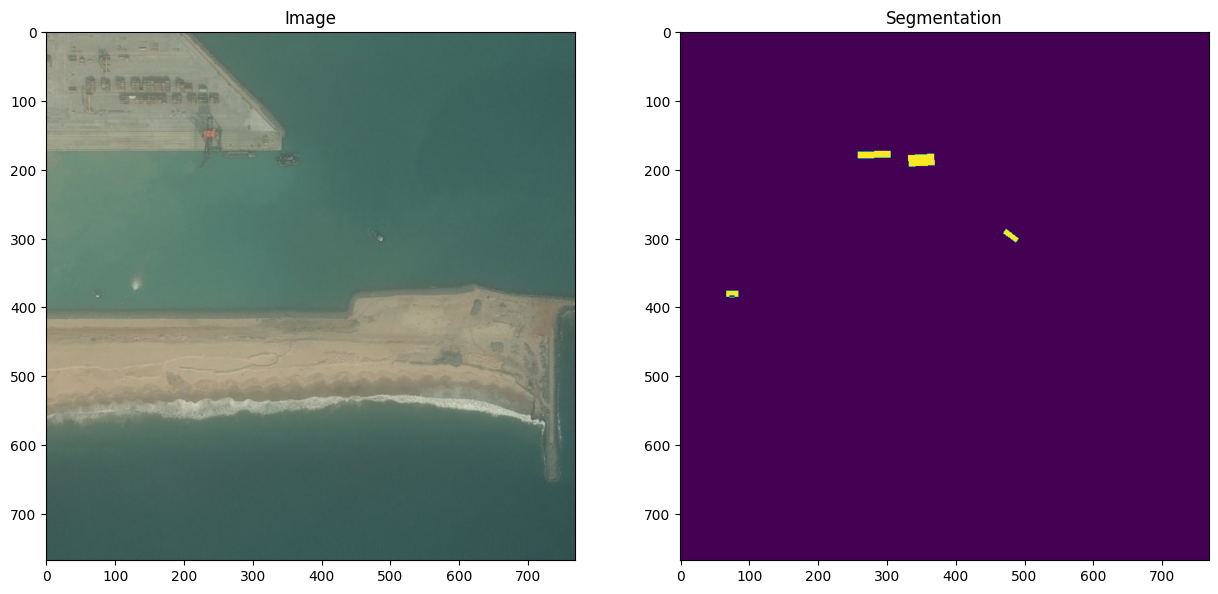

In [17]:
display_image_with_segmentation('000194a2d.jpg', full_segmentation, TRAIN_FOLDER)